In [36]:
import json
import collections
import pandas as pd
import numpy as np
import yaml
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

In [54]:
with open('views') as data_file:    
    views = yaml.safe_load(data_file)
    
num_views = len(views['rows'])
df_s = []
for i in range(num_views):
    df = pd.DataFrame(views['rows'][i]['doc'])
    df_s.append(df)
views = pd.concat(df_s)
views.reset_index(inplace = True, drop = True)

views.head()

,_id,_rev,frames,video
0,01f56ea8ff86a86279a6146658a1d365,12-913ce90ff2ae7e8df3804f7403fc7c97,"{u'emojis': {u'stuckOutTongue': 2.29777979851,...",3ZqPaohVjmw
1,01f56ea8ff86a86279a6146658a1d365,12-913ce90ff2ae7e8df3804f7403fc7c97,"{u'emojis': {u'stuckOutTongue': 2.29783821106,...",3ZqPaohVjmw
2,01f56ea8ff86a86279a6146658a1d365,12-913ce90ff2ae7e8df3804f7403fc7c97,"{u'emojis': {u'stuckOutTongue': 2.29872449239,...",3ZqPaohVjmw
3,01f56ea8ff86a86279a6146658a1d365,12-913ce90ff2ae7e8df3804f7403fc7c97,"{u'emojis': {u'stuckOutTongue': 2.29910651843,...",3ZqPaohVjmw
4,01f56ea8ff86a86279a6146658a1d365,12-913ce90ff2ae7e8df3804f7403fc7c97,"{u'emojis': {u'stuckOutTongue': 2.2984726429, ...",3ZqPaohVjmw


In [42]:
import data as data_py

In [346]:
# data_py.change_mode_to_prod()
# userItems = data_py.getUserItems()

In [55]:
df_useritem = pd.DataFrame(userItems)
print df_useritem.columns.values
df_useritem.shape

[u'user_id' u'video_id']


(140, 2)

In [56]:
print len(df_useritem[u'video_id'].unique())
print len(df_useritem[u'user_id'].unique())

70
19


In [57]:
with open('content') as data_file:    
    content = yaml.safe_load(data_file)
content['total_rows']

68

In [61]:
with open('users') as data_file:    
    users = yaml.safe_load(data_file)

num_users = len(users['rows'])
all_users = {}
active_users = {}
info_users = {}
df_s = []

for i in range(num_users):
    user = users['rows'][i]['doc']
    if not '_design' in user['_id']:
        all_users[user['_id']] = user['views']
        if len(user['views']) > 0:
            active_users[user['login']] = user['views']
        
print len(all_users)
print len(active_users)

37
19


In [62]:
views = views.drop(['_rev'], 1)

In [331]:
gr = views.drop('frames', 1).groupby(['video', '_id']).count()
gr = gr.reset_index()
gr = gr.groupby(['video']).count()
gr = gr.reset_index()
gr.head()

,video,_id
0,1zyQ6c7hNG4,2
1,3ZqPaohVjmw,12
2,7QLSRMoKKS0,4
3,8HlqSrCazqo,1
4,8szwlCnKUbY,2


In [333]:
gr[gr._id > 3]

,video,_id
1,3ZqPaohVjmw,12
2,7QLSRMoKKS0,4
12,EFpwgXCwMNQ,10
14,Fc1P-AEaEp8,4
36,_OBlgSz8sSM,4
46,he2a4xK8ctk,4
52,q1LSv468kzI,4
55,sJgDYdA8dio,4
64,wgTZUU4gJ2U,4


In [64]:
gr = gr.groupby(['_id']).count()
gr = gr.reset_index()
gr

,_id,video
0,1,35
1,2,21
2,3,3
3,4,7
4,10,1
5,12,1


In [65]:
zero_views = content['total_rows'] - sum(gr.video)
gr.loc[-1] = [0, zero_views]  # adding a row
gr.index = gr.index + 1  # shifting index
gr = gr.sort_index()  # sorting by index
gr = gr.rename(columns = {'_id':'Watch_count'})

In [66]:
gr

,Watch_count,video
0,0,0
1,1,35
2,2,21
3,3,3
4,4,7
5,10,1
6,12,1


In [67]:
sum(gr.video)-19

49

In [69]:
all_frames = {}

for row in range(0, views.shape[0]):
    if views['video'][row] in all_frames:
        all_frames[views['video'][row]].extend([views['frames'][row]])
    else:
        all_frames[views['video'][row]] = [views['frames'][row]]

In [70]:
views['frames'].count()

786

In [71]:
frames_for_active_users = {}
for key, value in active_users.iteritems():
    frames_for_user = []
    for v in value:
        if v in all_frames:
            frames_for_user.extend(all_frames[v])
    frames_for_active_users[key] = frames_for_user

In [112]:
def get_data(sample):
    emotions = {}
    emotions['emojis'] = []
    emotions['emotions'] = []
    for frame in sample:
        for key in frame:
            if key == 'emojis':
                emotions['emojis'].append(frame[key])
            if key == 'emotions':
                emotions['emotions'].append(frame[key])
    emotions_sum = {}
    for emotion in emotions:
        emotions_sum[emotion] = {}
        for feelings in emotions[emotion]:
            for feeling in feelings.keys():
                if feeling in emotions_sum[emotion]:
                    emotions_sum[emotion][feeling] += feelings[feeling]
                else:
                    emotions_sum[emotion][feeling] = feelings[feeling]
    count = len(emotions)*1.
    for emotion in emotions_sum:
        for feeling in emotions_sum[emotion]:
#             print 'before: ', emotions_sum[emotion][feeling]
            emotions_sum[emotion][feeling] = emotions_sum[emotion][feeling] / count
#             print 'after:' , emotions_sum[emotion][feeling]
    return emotions_sum

In [580]:
dfs = []
video_ids = []
for sample in all_frames:
    video_ids.append(sample)
    data = get_data(all_frames[sample])
    emotions = pd.DataFrame.from_dict(data['emotions'].items())
    emojis = pd.DataFrame.from_dict(data['emojis'].items())
    dfs.append(pd.concat([emojis, emotions]))
print len(dfs)
df_final = pd.merge(dfs[0], dfs[1], on=0)
df_final = df_final.drop('0_x', 1)
for i in range(2, len(dfs)):
    df_final = pd.merge(df_final, dfs[i], on=0)
    df_final = df_final.drop('0_x', 1)

print df_final.shape
df_final = df_final.transpose()
df_final.columns = df_final.iloc[0]
df_final = df_final.drop(0, 0)
print df_final.shape
df_final.reset_index(inplace=True)
df_final = df_final.drop('index', 1)
df_final.head()

68
(21, 69)
(68, 21)


,stuckOutTongue,stuckOutTongueWinkingEye,rage,smirk,relaxed,smiley,wink,laughing,kissing,flushed,...,scream,joy,engagement,sadness,disgust,anger,surprise,fear,valence,contempt
0,3.46055,3.4483,0.0142802,3.63897e-06,25.1386,0.00242341,0.00276765,0.00259284,0.00300459,0.00274375,...,0.0421018,28.6354,33.44,0.0307967,0.405705,0.0142802,0.267185,0.00577506,21.9661,0.221006
1,10.2315,10.2315,15.6259,6.13877,36.4294,0.0283216,1.74267,0.0393411,0.00833377,0.0081455,...,0.126166,36.3421,84.1025,16.0427,5.31359,15.6259,0.915081,0.939588,-4.63076,43.9247
2,3.44677,3.44677,0.0042843,2.94193e-06,68.1162,0.0108895,0.00275205,0.0221637,0.00295644,0.00274396,...,0.0420521,72.3433,72.7509,0.0192143,0.341292,0.0042843,0.289394,0.00367549,21.3045,0.152705
3,20.6504,20.6495,0.0371721,2.14115,79.4517,65.5611,0.129805,0.101389,0.0370914,0.0164397,...,0.26481,171.2,181.229,0.17279,3.00826,0.0371721,15.7884,0.0556079,153.298,11.0631
4,25.3576,26.9822,0.9285,0.789662,68.9127,111.122,329.349,8.535,0.0201784,0.0251139,...,28.1978,270.613,524.376,2.84676,177.628,0.9285,120.79,7.75883,52.448,16.7593


In [589]:
titles = []
id_title = {}
for item in content['rows']:
    id_title[item['doc']['video_id']] = item['doc']['title']
    
len(id_title)

68

In [595]:
id_title_df = pd.DataFrame.from_dict(id_title.items())
id_title_df.columns = ['video_id', 'title']
id_title_df.head(2)

,video_id,title
0,8xeBGx2bfxc,Amazing Bear Recreation!
1,BUS6nKpddec,Reporter turns ghetto in 3 seconds


In [614]:
merged = df_final
merged['video_id'] = video_ids
merged.head()

,stuckOutTongue,stuckOutTongueWinkingEye,rage,smirk,relaxed,smiley,wink,laughing,kissing,flushed,...,joy,engagement,sadness,disgust,anger,surprise,fear,valence,contempt,video_id
0,3.46055,3.4483,0.0142802,3.63897e-06,25.1386,0.00242341,0.00276765,0.00259284,0.00300459,0.00274375,...,28.6354,33.44,0.0307967,0.405705,0.0142802,0.267185,0.00577506,21.9661,0.221006,8xeBGx2bfxc
1,10.2315,10.2315,15.6259,6.13877,36.4294,0.0283216,1.74267,0.0393411,0.00833377,0.0081455,...,36.3421,84.1025,16.0427,5.31359,15.6259,0.915081,0.939588,-4.63076,43.9247,BUS6nKpddec
2,3.44677,3.44677,0.0042843,2.94193e-06,68.1162,0.0108895,0.00275205,0.0221637,0.00295644,0.00274396,...,72.3433,72.7509,0.0192143,0.341292,0.0042843,0.289394,0.00367549,21.3045,0.152705,DzlH5SDGoyA
3,20.6504,20.6495,0.0371721,2.14115,79.4517,65.5611,0.129805,0.101389,0.0370914,0.0164397,...,171.2,181.229,0.17279,3.00826,0.0371721,15.7884,0.0556079,153.298,11.0631,d5mK7dzyUkM
4,25.3576,26.9822,0.9285,0.789662,68.9127,111.122,329.349,8.535,0.0201784,0.0251139,...,270.613,524.376,2.84676,177.628,0.9285,120.79,7.75883,52.448,16.7593,zDdYn4UAB48


In [615]:
merged = pd.merge(merged, id_title_df, on = 'video_id')
merged.columns.values

array(['stuckOutTongue', 'stuckOutTongueWinkingEye', 'rage', 'smirk',
       'relaxed', 'smiley', 'wink', 'laughing', 'kissing', 'flushed',
       'disappointed', 'scream', 'joy', 'engagement', 'sadness', 'disgust',
       'anger', 'surprise', 'fear', 'valence', 'contempt', 'video_id',
       'title'], dtype=object)

In [618]:
merged.shape

(66, 23)

In [607]:
for id in merged.video_id:
    if id not in id_title_df.video_id.values:
        print id

3ZqPaohVjmw
7QLSRMoKKS0


In [477]:
for col in df_final.columns.values:
    df_final[col] = pd.to_numeric(df_final[col])

In [77]:
def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0: 
        return v
    return v/norm

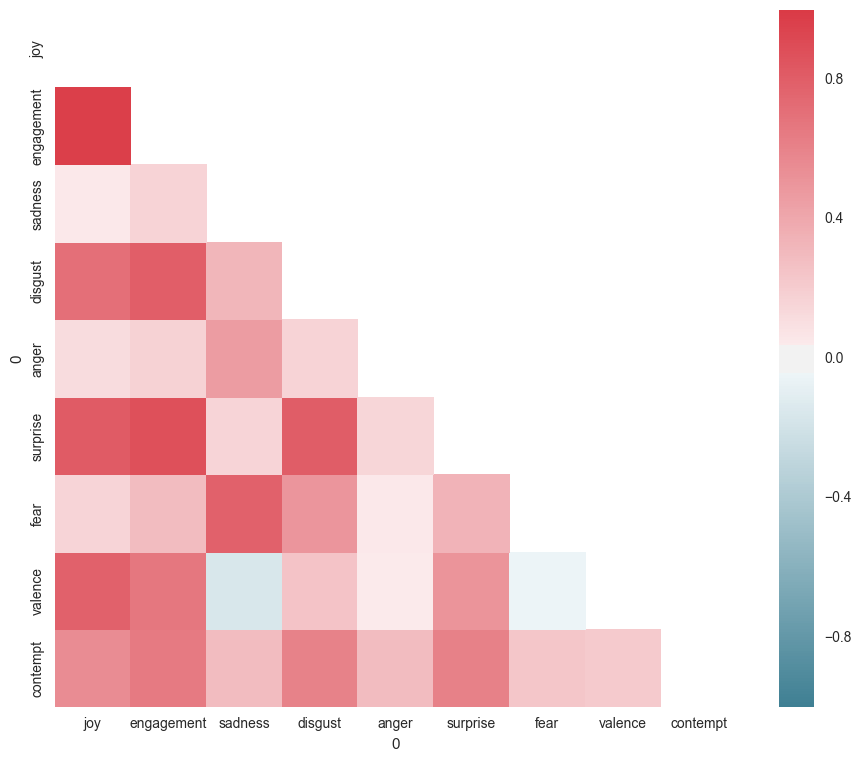

In [484]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df_final[['joy', 'engagement', 'sadness', 'disgust',
       'anger', 'surprise', 'fear', 'valence', 'contempt']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
#             square=True, xticklabels=5, yticklabels=5,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax)

In [485]:
# numpyMatrix = df_final[['engagement', 'sadness', 'contempt', 'laughing', 'surprise', 'joy']].as_matrix()
numpyMatrix = df_final.as_matrix()
# for i in range(numpyMatrix.shape[0]):
#     numpyMatrix[i] = normalize(numpyMatrix[i])

In [322]:
# mini = df_final[['joy', 'laughing', 'sadness', 'disgust', 'anger', 'surprise', 'contempt']]
# mini  = (mini  - mini .mean()) / (mini .max() - mini .min())
# numpyMatrix = mini.as_matrix()
# # for i in range(numpyMatrix.shape[0]):
# #     numpyMatrix[i] = normalize(numpyMatrix[i])
# labels = mini.idxmax(axis=1)
# mini.head(2)

,joy,laughing,sadness,disgust,anger,surprise,contempt
0,-0.097662,-0.075399,-0.066476,-0.066990,-0.037420,-0.100006,-0.134094
1,-0.090486,-0.071093,0.233285,-0.058069,0.332355,-0.097179,0.047071


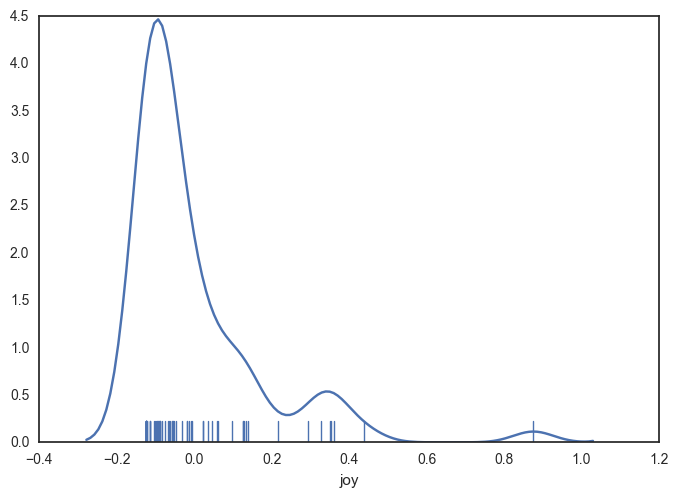

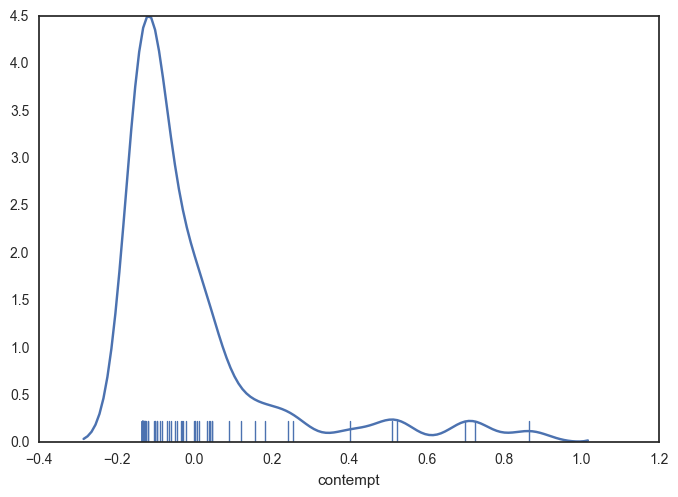

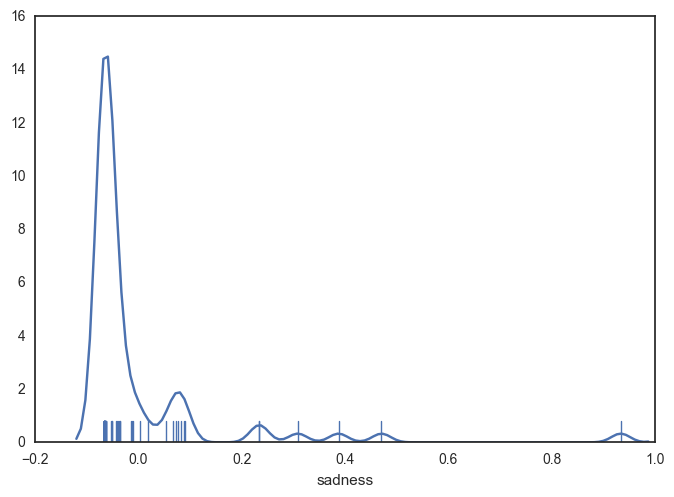

In [327]:
# from scipy import stats, integrate

# names = ['joy', 'contempt', 'sadness']

# for name in names:
#     x = mini[name]
#     sns.distplot(x, hist=False, rug=True);
#     plt.show()

In [578]:
mini.head(2)

,joy,laughing,sadness,disgust,anger,surprise,contempt
0,-0.097662,-0.075399,-0.066476,-0.066990,-0.037420,-0.100006,-0.134094
1,-0.090486,-0.071093,0.233285,-0.058069,0.332355,-0.097179,0.047071


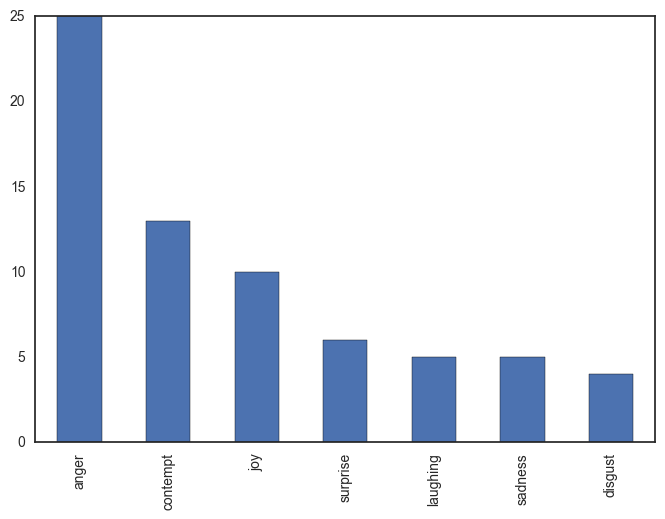

In [579]:
pd.value_counts(labels).plot(kind='bar')

Automatically created module for IPython interactive environment
Computing t-SNE embedding
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 68 / 68
[t-SNE] Mean sigma: 21.700911
[t-SNE] Error after 100 iterations with early exaggeration: 1.346664
[t-SNE] Error after 350 iterations: 1.237806


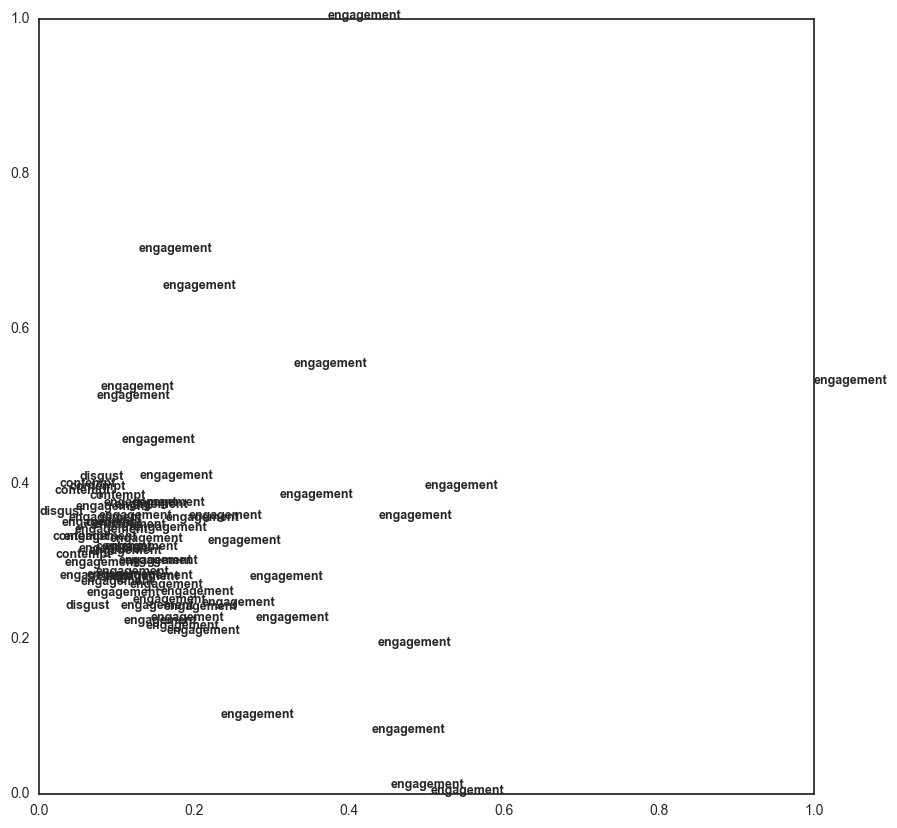

In [577]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011
# http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
sns.set(style="white")

from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

# digits = datasets.load_digits(n_class=6)
# X = digits.data
X = numpyMatrix
# y = labels
n_samples, n_features = X.shape
n_neighbors = 2


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
#     for i in range(X.shape[0]):
#         plt.scatter(X[i, 0], X[i, 1])
        
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], y[i],
                 fontdict={'weight': 'bold', 'size': 9})

#     if hasattr(offsetbox, 'AnnotationBbox'):
#         # only print thumbnails with matplotlib > 1.0
#         shown_images = np.array([[1., 1.]])  # just something big
#         for i in range(digits.data.shape[0]):
#             dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
#             shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#                 X[i])
#             ax.add_artist(imagebox)
#     plt.xticks([]), plt.yticks([])
#     if title is not None:
#         plt.title(title)

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity = 5, learning_rate = 200, n_iter = 5000, verbose = 1)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)
#,
#                "t-SNE embedding of the digits (time %.2fs)" %
#                (time() - t0))

plt.show()

In [350]:
views_to_consider = ['10375dc950ecafa8bcb62fa8ac7bb039', '2592fb1f9968e90490f58109d4ca2900', 'e8d04fa91ecc39f1f1c3974b784d99f2']

In [519]:
# titanic = sns.load_dataset("titanic")
# titanic = titanic.assign(deck=titanic.deck.astype(object)).sort("deck")
# g = sns.FacetGrid(titanic, col="class", sharex=False,
#                   gridspec_kws={"width_ratios": [5, 3, 3]})
# g.map(sns.boxplot, "deck", "age");

In [548]:
video = views[views.video == '_OBlgSz8sSM']
a = video[video._id == '10375dc950ecafa8bcb62fa8ac7bb039']
b = video[video._id == '2592fb1f9968e90490f58109d4ca2900']
c = video[video._id == 'e8d04fa91ecc39f1f1c3974b784d99f2']
a_frames = list(a.frames)
b_frames = list(b.frames)
c_frames = list(c.frames)

In [549]:
a_data = get_data_users(a_frames)
b_data = get_data_users(b_frames)
c_data = get_data_users(c_frames)

In [550]:
def get_df(data, user_id):
    emotions = []
    emojis = []
    for emot in data['emotions']:
        emotions.append(pd.DataFrame.from_dict(emot.items()))
    for emoj in data['emojis']:
        emojis.append(pd.DataFrame.from_dict(emoj.items()))
    
    emotion_abc = pd.merge(emotions[0], emotions[1], on=0)
    emotion_abc = emotion_abc.drop('0_x', 1)
    for i in range(2, len(emotions)):
        emotion_abc = pd.merge(emotion_abc, emotions[i], on=0)
        emotion_abc = emotion_abc.drop('0_x', 1)
    emotion_abc

    emojis_abc = pd.merge(emojis[0], emojis[1], on=0)
    emojis_abc = emojis_abc.drop('0_x', 1)
    for i in range(2, len(emojis)):
        emojis_abc = pd.merge(emojis_abc, emojis[i], on=0)
        emojis_abc = emojis_abc.drop('0_x', 1)
    emojis_abc

    result = pd.concat([emojis_abc, emotion_abc])

    result = result.transpose()
    result.columns = result.iloc[0]
    result = result.drop(0, 0)
    result.reset_index(inplace=True)
    result = result.drop('index', 1)
    result['user'] = user_id
    return result


df_a = get_df(a_data, 'A')
df_b = get_df(b_data, 'B')
df_c = get_df(c_data, 'C')
print df_a.shape
print df_b.shape
print df_c.shape

(12, 22)
(12, 22)
(12, 22)


In [555]:
df_abc = pd.concat([df_a, df_b, df_c])

In [557]:
for col in df_abc.columns.values:
    if col != 'user':
        df_abc[col] = pd.to_numeric(df_abc[col])

In [567]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

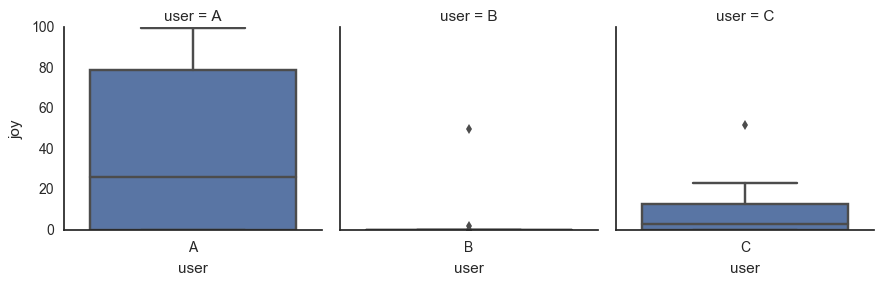

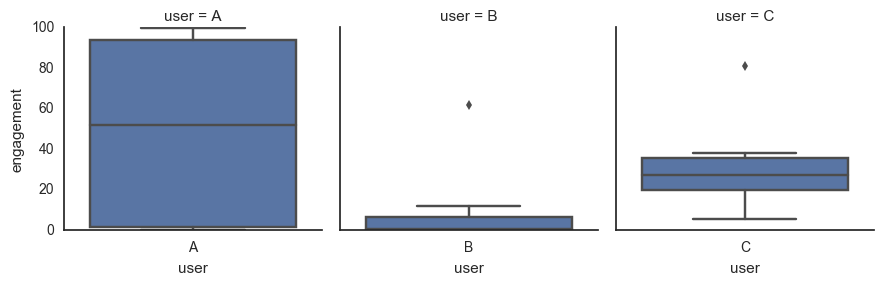

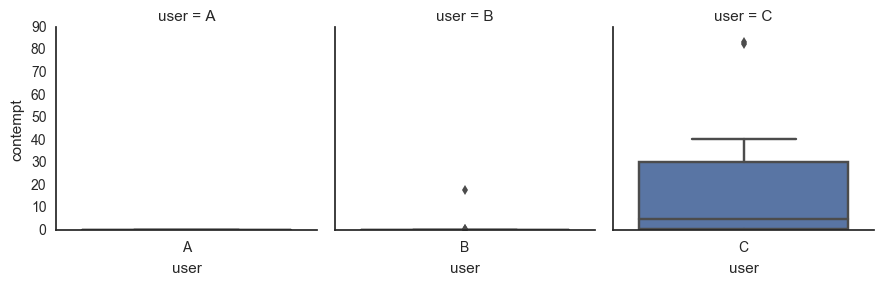

In [573]:
# data = result.assign(user=df_abc.astype(object)).sort("user")
for col in df_abc.columns.values:
    if col in ['joy', 'engagement', 'contempt']:
        g = sns.FacetGrid(df_abc, col="user", sharex=False,)
        g.map(sns.boxplot, "user", col);
#         plt.show()

In [619]:
print merged.shape
merged.columns.values

(66, 23)


array(['stuckOutTongue', 'stuckOutTongueWinkingEye', 'rage', 'smirk',
       'relaxed', 'smiley', 'wink', 'laughing', 'kissing', 'flushed',
       'disappointed', 'scream', 'joy', 'engagement', 'sadness', 'disgust',
       'anger', 'surprise', 'fear', 'valence', 'contempt', 'video_id',
       'title'], dtype=object)

In [633]:
merged = merged[['joy', 'disgust', 'surprise', 'contempt', 'video_id',
       'title']]

In [634]:
for col in merged.columns.values:
    if col != 'video_id' and col != 'title':
        merged[col] = pd.to_numeric(merged[col])

C:\Users\Evelina\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [635]:
merged_np = merged.ix[:,: merged.shape[1] - 2].as_matrix()

In [636]:
for i in range(merged_np.shape[0]):
    merged_np[i] = normalize(merged_np[i])

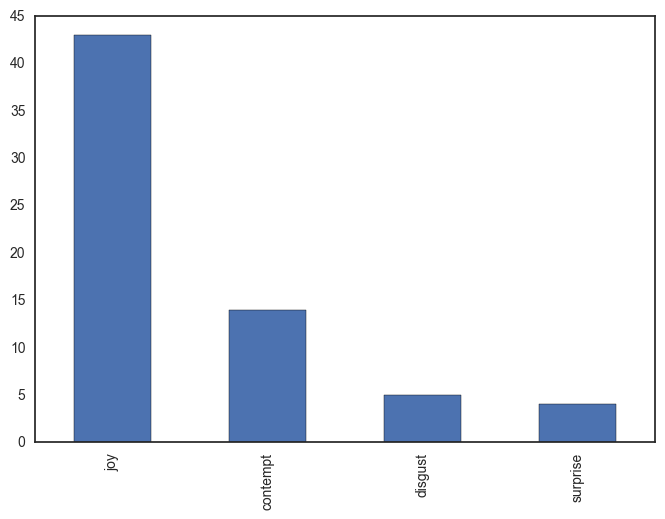

In [638]:
merged_labels = merged.ix[:,:merged.shape[1] - 2].idxmax(axis=1)
pd.value_counts(merged_labels).plot(kind='bar')

Computing t-SNE embedding
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 0.016616
[t-SNE] Error after 100 iterations with early exaggeration: 0.578935
[t-SNE] Error after 325 iterations: 0.487583


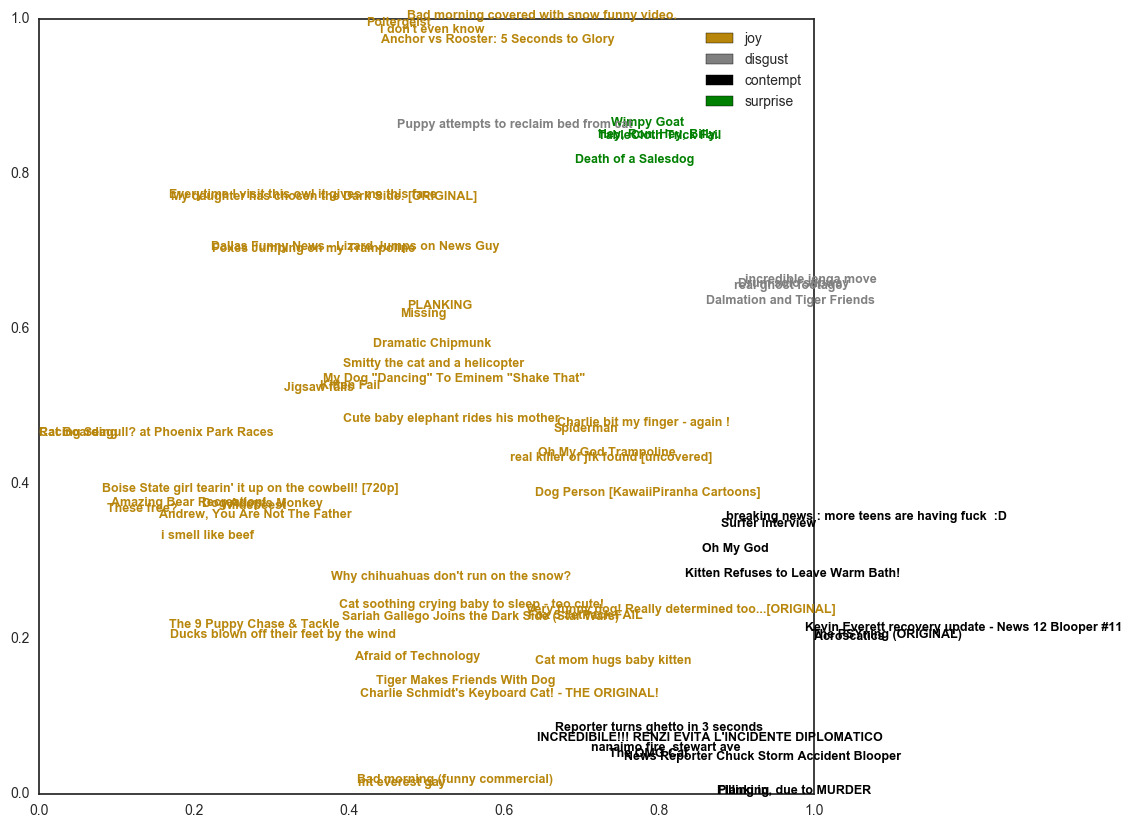

In [681]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# digits = datasets.load_digits(n_class=6)
# X = digits.data
X = merged_np
y = merged.title
n_samples, n_features = X.shape
n_neighbors = 2


def get_label(i):
    return merged_labels[i] 
    
color_label = {'joy':{'label' : 'joy', 'color' : 'darkgoldenrod'}, 'contempt': {'label' : 'contempt', 'color': 'black'}, 
              'disgust': {'label' : 'disgust', 'color' : 'gray'}, 'surprise': {'label' : 'surprise', 'color' : 'green'}}

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
#     for i in range(X.shape[0]):
#         plt.scatter(X[i, 0], X[i, 1])
        
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], y[i],
                 fontdict={'weight': 'bold', 'size': 9}, color=color_label[get_label(i)]['color'], label='1')
#                  label=color_label[get_label(i)]['label'])
    p = []
    a = []
    for item in color_label:
        p.append(Rectangle((0, 0), 1, 1, fc=color_label[item]['color']))
        a.append(color_label[item]['label'])

    plt.legend(p, a)
    plt.show()
#     if hasattr(offsetbox, 'AnnotationBbox'):
#         # only print thumbnails with matplotlib > 1.0
#         shown_images = np.array([[1., 1.]])  # just something big
#         for i in range(digits.data.shape[0]):
#             dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
#             shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#                 X[i])
#             ax.add_artist(imagebox)
#     plt.xticks([]), plt.yticks([])
#     if title is not None:
#         plt.title(title)

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity = 2, learning_rate = 20, n_iter = 5000, verbose = 1)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)
#,
#                "t-SNE embedding of the digits (time %.2fs)" %
#                (time() - t0))

